<a href="https://colab.research.google.com/github/saikalyanmatta/UDIS-Project/blob/master/UDIS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/saikalyanmatta/UDIS-Project.git
%cd UDIS-Project
!ls



Cloning into 'UDIS-Project'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 609 (delta 0), reused 2 (delta 0), pack-reused 606 (from 1)
Receiving objects: 100% (609/609), 60.32 MiB | 25.88 MiB/s, done.
/content/UDIS-Project
data  gradcam.py  infer.py  models  preprocess	train.py  utils.py


In [7]:
%run train.py


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5] | Loss: 18.3276 | Train Acc: 0.8757 | Val Acc: 0.8833
✅ Best model saved
Epoch [2/5] | Loss: 11.8305 | Train Acc: 0.9290 | Val Acc: 0.9083
✅ Best model saved
Epoch [3/5] | Loss: 8.0212 | Train Acc: 0.9566 | Val Acc: 0.9500
✅ Best model saved
Epoch [4/5] | Loss: 6.3089 | Train Acc: 0.9842 | Val Acc: 0.9167
Epoch [5/5] | Loss: 4.2204 | Train Acc: 0.9941 | Val Acc: 0.9417
Training complete.
Best Validation Accuracy: 0.95


In [9]:
# load the best model

import torch
from models.model import DamageNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DamageNet().to(device)
model.load_state_dict(
    torch.load("models/best_damage_model.pth", map_location=device)
)
model.eval()

print("Model loaded successfully on", device)


Model loaded successfully on cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


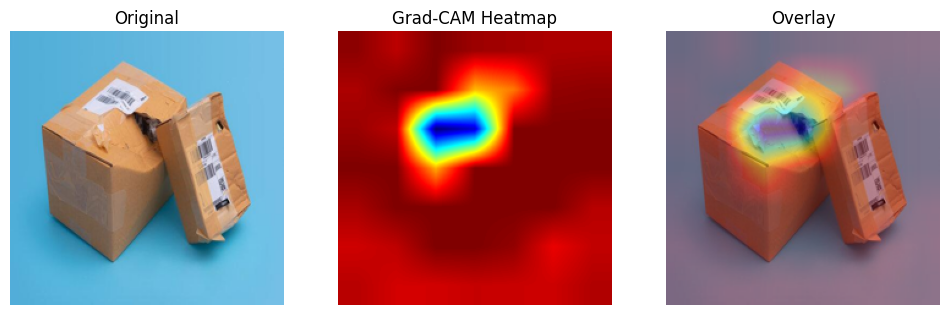

Prediction: Damaged


In [10]:
# gradcam visualisation

import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

target_layer = model.model.features[-1]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(1).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, class_idx

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


img_path = "data/val/damaged/packagingboxesthataredamaged175.jpeg"

img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

gradcam = GradCAM(model, target_layer)
cam, pred_class = gradcam.generate(input_tensor)


img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()


class_names = ["Damaged", "Intact"]
print("Prediction:", class_names[pred_class])



Model loaded for evaluation.
Classes: ['damaged', 'intact']


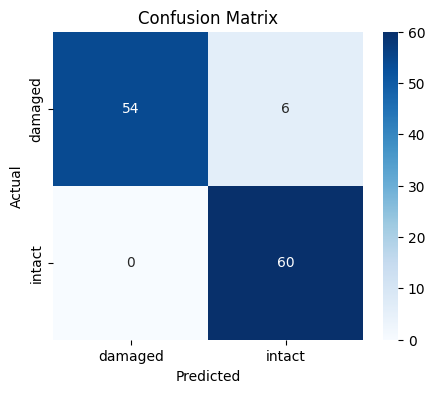

              precision    recall  f1-score   support

     damaged       1.00      0.90      0.95        60
      intact       0.91      1.00      0.95        60

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



In [16]:
# calculate metrics

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from models.model import DamageNet
from utils import get_dataloaders

# best model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DamageNet().to(device)
model.load_state_dict(
    torch.load("models/best_damage_model.pth", map_location=device)
)
model.eval()

print("Model loaded for evaluation.")

# validator data
_, val_dataset = get_dataloaders("data")

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False
)

class_names = val_dataset.classes
print("Classes:", class_names)

# predicted results

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# confusion matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names
)

print(report)




In [42]:
!ls /content/notebooks
